In [211]:
from load_data import DATA_DIR

import os
import json
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

P53_CLASS_CODES = ["WT", "OE", "NM", "DC"]

BOLERO_DIR = os.path.join(DATA_DIR, '..', 'BOLERO')
PATHXL_DIR = os.path.join(DATA_DIR, '..', 'p53_consensus_study')

BASE_DIR = {
    'test': DATA_DIR,
    'pathxl': PATHXL_DIR,
    'bolero': BOLERO_DIR,
}

color_dict = {
    "r": '#DA4C4C', # Red
    "o": '#E57439', # Orange
    "y": '#EDB732', # Yellow
    "g": '#479A5F', # Green
    "lb": '#5BC5DB', # Light blue
    "b": '#5387DD', # Blue
    "p": '#7D54B2', # Purple
    "pi": '#E87B9F', # Pink
#  '#229487', # Dark green/Turquoise
#  '#C565C7', # Lilac
    "r_p": '#E89393', # Pale red
    "o_p": '#EFAB88', # Pale orange
    "y_p": '#F4D384', # Pale yellow
    "g_p": '#90C29F', # Pale green
    "lb_p":'#9CDCE9', # Pale light blue
    "b_p": '#98B7EA', # Pale blue
    "p_p": "#B198D0", # Pale purple
}

C:\Users\321lu\AppData\Local\Temp\ipykernel_27372\3512912214.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Distribution

In [226]:
def get_labels(data_name):
    if data_name == "test":
        return pd.read_csv(os.path.join(BASE_DIR[data_name], 'test.csv')).set_index("id")
    elif data_name == "train":
        return pd.read_csv(os.path.join(BASE_DIR['test'], 'train.csv')).set_index("id")
    elif data_name == "bolero":
        labels = pd.read_csv(os.path.join(BASE_DIR[data_name], 'P53_BOLERO_T.csv'))
        labels = labels.sort_values(by="Case ID")
        labels = labels.reset_index(drop=True)
        # Map GS to {1:0, 2:1, 3:2, 4:4} where 4 is unknown
        labels["label"] = labels["GS"].map({1:0, 2:1, 3:2, 4:4})
        return labels
    elif data_name == "pathxl":
        labels = pd.read_csv(os.path.join(BASE_DIR[data_name], 'labels.csv'))
        # idx is id column and biopsy_nr column separated by _
        labels["idx"] = labels["id"].astype(str) + "_" + labels["biopsy_nr"].astype(str)
        labels = labels.set_index("idx")
        # Sort by id primarily and biopsy_nr secondarily
        labels = labels.sort_values(by=["id", "biopsy_nr"])
        # Map label
        mapping = {"WT":0, "Overexpression":1, "Null":2, "Double clones":3}
        labels["label"] = labels["label"].map(mapping)
        # Filter out any concordance % < 100
        labels = labels[labels["concordance %"] == 100]
        return labels

# Make LaTeX table of label counts
table = ""
table += "Dataset & Level & Total & WT & OE & NM & DC & X \\\\ \n"

for i, data_name in enumerate(["train", "test", "pathxl", "bolero"]):
    labels = get_labels(data_name)
    # print(f"Dataset: {data_name}")
    value_counts = labels["label"].value_counts()
    # print(value_counts)
    # print()

    table += f'{["train", "test 1", "test 2", "BOLERO"][i]} & '
    table += f'{["biopsy", "biopsy", "biopsy", "WSI"][i]} & '
    table += f"{len(labels)} & "
    for j, code in enumerate(P53_CLASS_CODES+["X"]):
        table += f"{value_counts.get(j, 0)} & "
    table += "\\\\ \n"

print(table)

Dataset & Level & Total & WT & OE & NM & DC & X \\ 
train & biopsy & 1472 & 1125 & 251 & 96 & 0 & 0 & \\ 
test 1 & biopsy & 60 & 15 & 15 & 15 & 15 & 0 & \\ 
test 2 & biopsy & 483 & 370 & 55 & 29 & 29 & 0 & \\ 
BOLERO & WSI & 55 & 22 & 28 & 4 & 0 & 1 & \\ 



# Biopsy Dimensions

In [141]:
for data_name in ['test', 'pathxl', 'bolero']:
    if os.path.exists(os.path.join(BASE_DIR[data_name], 'biopsy_dims.json')):
        continue
    print(data_name)

    biopsy_dims = {}
    for img_filename in tqdm(os.listdir(os.path.join(BASE_DIR[data_name], 'biopsies'))):
        img = plt.imread(os.path.join(BASE_DIR[data_name], 'biopsies', img_filename))
        biopsy_dims[img_filename.split('.')[0]] = img.shape[:2]

    with open(os.path.join(BASE_DIR[data_name], 'biopsy_dims.json'), 'w') as f:
        json.dump(biopsy_dims, f)

test 5.330938
pathxl 6.388872
bolero 5.630974


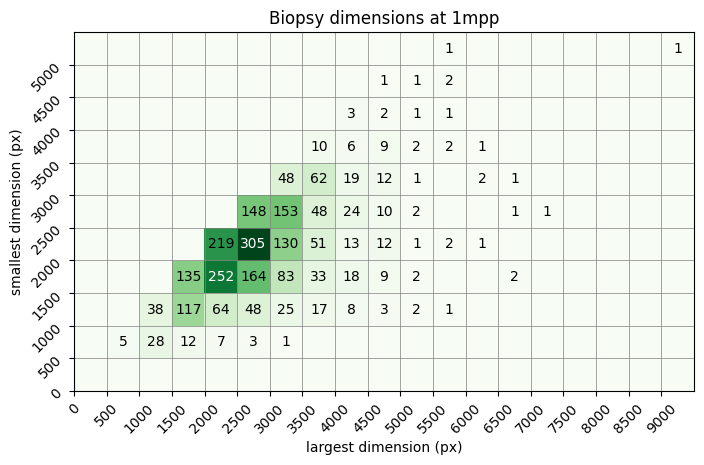

In [147]:
biopsy_dims = {}

for data_name in ['test', 'pathxl', 'bolero']:
    with open(os.path.join(BASE_DIR[data_name], 'biopsy_dims.json')) as f:
        b_dims = json.load(f) # dict of biopsy dimensions (height, width)

    # Print median size in megapixels
    print(data_name, np.median([dim[0] * dim[1] for dim in b_dims.values()]) / 1e6)

    biopsy_dims.update({f'{data_name}_{k}': v for k, v in b_dims.items()})

# Sort so that the smallest dimension out of height and width is first
biopsy_dims = {k: tuple(sorted(v)) for k, v in biopsy_dims.items()}

# Make heatmap of biopsy dimensions in bins of {binsize} px
binsize = 500
max_dim0 = max(dim[0] for dim in biopsy_dims.values())
max_dim1 = max(dim[1] for dim in biopsy_dims.values())
bin_count0 = max_dim0 // binsize + 1
bin_count1 = max_dim1 // binsize + 1
bins = np.zeros((bin_count0, bin_count1))
for dim in biopsy_dims.values():
    i = dim[0] // binsize
    j = dim[1] // binsize
    bins[i, j] += 1
max_count = np.max(bins)


# Plot heatmap
plt.figure(figsize=(8,8))
plt.imshow(bins, cmap='Greens', interpolation='nearest') # good colormaps: hot, jet, viridis
plt.gca().invert_yaxis()
plt.yticks(np.arange(bin_count0)-0.5, [str(i * binsize) for i in range(bin_count0)], rotation=45)
plt.xticks(np.arange(bin_count1)-0.5, [str(i * binsize) for i in range(bin_count1)], rotation=45)
# put text on heatmap
for i in range(bin_count0):
    for j in range(bin_count1):
        if bins[i, j] == 0:
            continue
        color = 'black' if bins[i, j] < max_count * 0.75 else 'white'
        plt.text(j, i, str(int(bins[i, j])), color=color, ha='center', va='center')
# plt.colorbar()
plt.title('Biopsy dimensions at 1mpp')
plt.ylabel('smallest dimension (px)')
plt.xlabel('largest dimension (px)')
# Add grid lines between bins
for i in range(bin_count0):
    plt.axhline(i - 0.5, color='grey', linewidth=0.5)
for j in range(bin_count1):
    plt.axvline(j - 0.5, color='grey', linewidth=0.5)
plt.show()

# Spacing examples

In [131]:
# Show most square biopsies
# biopsy_dims_list = sorted(biopsy_dims.items(), key=lambda x: x[1][1] / x[1][0])
biopsy_dims_list = sorted(biopsy_dims.items(), key=lambda x: abs(x[1][0] - 2048))
leeway = 0.05
for i, (k, v) in enumerate(biopsy_dims_list[:]):
    if v[0] / v[1] > 1+leeway or v[0] / v[1] < 1-leeway:
        continue
    if abs(v[0] - 2048) > 0.05 * 2048:
        continue

    print(f'{i+1}. {k}: {v[0]}x{v[1]}')

    # plt.figure(figsize=(2, 2))
    # plt.imshow(plt.imread(os.path.join(DATA_DIR, 'biopsies', f'{k}.png')))
    # plt.axis('off')
    # plt.show()

2. 559: 2050x2115
11. 1398: 2040x2127
13. 387: 2058x2152
20. 1392: 2061x2166
22. 640: 2063x2095
23. 1121: 2063x2078
29. 1133: 2032x2052
33. 97: 2031x2136
38. 558: 2066x2149
60. 1003: 2023x2056
61. 444: 2075x2075
79. 194: 2012x2020
105. 1306: 2000x2032
112. 338: 1996x2096
118. 1261: 2101x2132
122. 1343: 1994x1994
128. 1117: 2104x2206
131. 1517: 2104x2189
135. 410: 1987x2072
141. 749: 1984x2040
151. 848: 1979x2013
152. 1154: 2118x2222
173. 981: 2128x2176
186. 417: 2135x2223
195. 1361: 2138x2153
210. 1294: 1952x2016
212. 567: 1951x2047


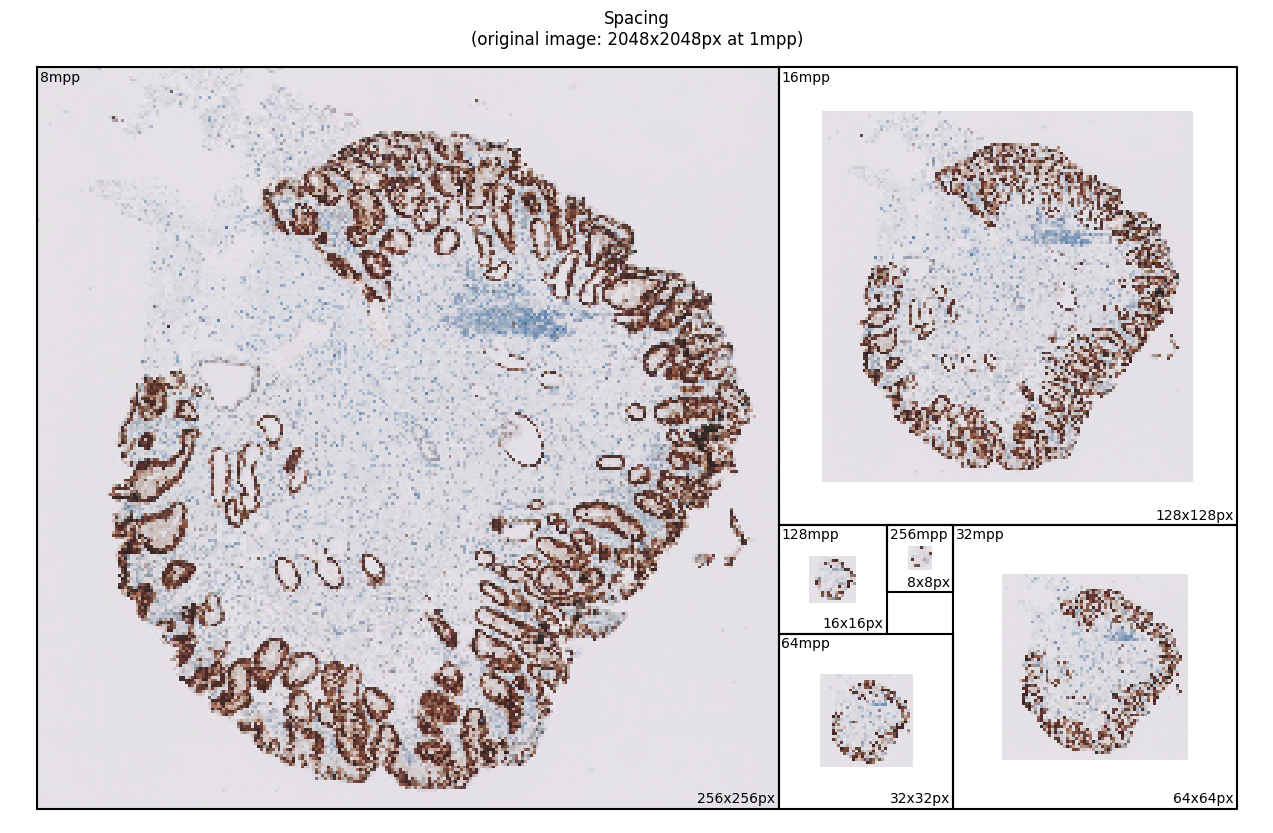

In [148]:
# Take biopsy img
# idx = 179
# idx = 1133
idx = 1361
img = plt.imread(os.path.join(DATA_DIR, 'biopsies', f'{idx}.png'))

img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), (2048, 2048)).squeeze().permute(1, 2, 0).numpy()
img_height = img.shape[0]
img_width = img.shape[1]

spacings = [8,16,32,64,128,256]

first_img_spacing_size = max(img.shape) // spacings[0]

# for spacing in spacings:
#     # Plot biopsy img
#     plt.imshow(img[::spacing, ::spacing])
#     plt.title(f'Biopsy image at {spacing}mpp')
#     plt.show()

# For aesthetic purposes, plot the biopsies in a golden ratio grid
# First calculate the cell positions for the golden ratio grid
golden_ratio = (1 + 5**0.5) / 2
cell_positions = []
# Start with the first cell at the origin
cell_width = first_img_spacing_size
x0, y0, x1, y1 = 0, 0, cell_width, cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x1
x1 = x0 + cell_width
y0 = y0
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x1 - cell_width
x1 = x0 + cell_width
y0 = y1
y1 = y1 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x0 - cell_width
x1 = x0 + cell_width
y0 = y1 - cell_width
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x0
x1 = x0 + cell_width
y0 = y0 - cell_width
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x1
x1 = x0 + cell_width
y0 = y0
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))

plt.figure(figsize=(10*golden_ratio, 10))

# First just plot the golden ratio grid
plt.axis('equal')
plt.axis('off')
plt.title('Spacing\n(original image: 2048x2048px at 1mpp)')

# Now plot the biopsies in the grid
for i, (x0, y0, x1, y1) in enumerate(cell_positions):
    sp = spacings[i]
    sub_img_width = img_width // sp
    sub_img_height = img_height // sp
    sub_img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), (sub_img_height, sub_img_width)).squeeze().permute(1, 2, 0).numpy()

    # Add text with spacing, and dimensions
    plt.text(x0+1, y0+1, f'{sp}mpp', color='black', ha='left', va='top')
    # In bottom right corner add text with dimensions
    plt.text(x1-1, y1-1, f'{sub_img_width}x{sub_img_height}px', color='black', ha='right', va='bottom')
    # Make extent center the image in the cell without stretching it
    x_center = (x0 + x1) / 2
    y_center = (y0 + y1) / 2
    x0 = x_center - sub_img_width / 2
    x1 = x_center + sub_img_width / 2
    y0 = y_center - sub_img_height / 2
    y1 = y_center + sub_img_height / 2
    # Make sure the pixels show up sharp
    plt.imshow(sub_img, extent=(x0, x1, y0, y1), interpolation='nearest')

# Add grid lines between golden ratio cells
for i, (x0, y0, x1, y1) in enumerate(cell_positions):
    plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-')


# Change extent to show all cells
plt.xlim(-5, golden_ratio * first_img_spacing_size+5)
plt.ylim(-5, first_img_spacing_size+5)
plt.gca().invert_yaxis()
plt.show()

pathxl_154_1 (3894, 3909)
pathxl_24_2 (3909, 3942)
pathxl_47_1 (4174, 4190)
pathxl_56_4 (4054, 4383)
pathxl_56_5 (4032, 4276)
pathxl_81_3 (3721, 4084)


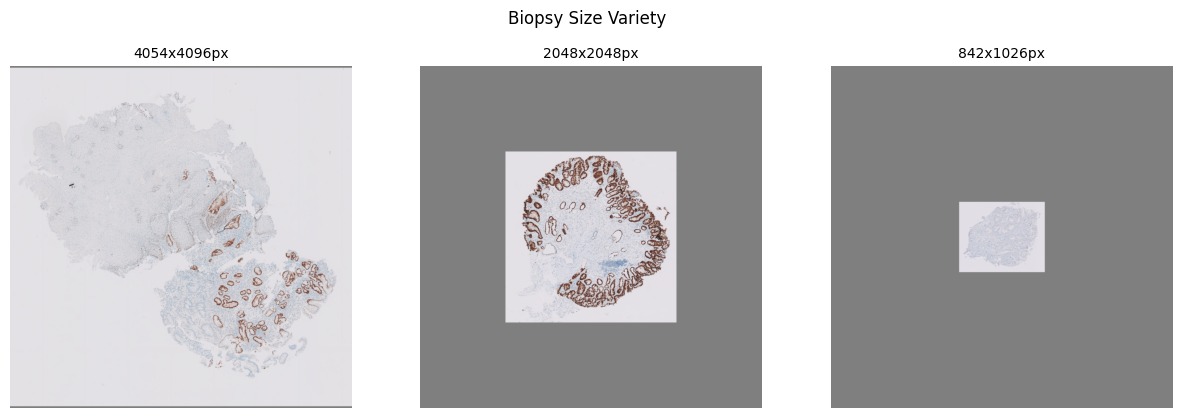

In [227]:
# Biopsies that have their largest side == 4096 (test 1410)
for k, v in biopsy_dims.items():
    if abs(v[0] - 4096) + abs(v[1] - 4096) < 400:
    # if max(v) > 9000:
        print(k, v)

# indices = [1385, 1361, 95, 352]
# indices = [1385, 1361, 95]
indices = [("pathxl", '56_4'), ('test', '1361'), ('test', '95')]

# Plot these biopsies from test in a row of 3
# Zero-pad them first into a frame of 4096x4096
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, idx in enumerate(indices):
    data_name, idx = idx
    img = plt.imread(os.path.join(BASE_DIR[data_name], 'biopsies', f'{idx}.png'))

    if i == 0:
        # Rotate 90 degrees
        # img = np.rot90(img)
        x = 100
        y = 0
        img = img[y:y+4096, x:x+4096]
    elif i == 1:
        # Reshape to 2048x2048
        img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), (2048, 2048)).squeeze().permute(1, 2, 0).numpy()

    frame = np.zeros((4096, 4096, 3))+0.5
    # Place the image in the center of the frame
    y = 2048 - img.shape[0]//2
    x = 2048 - img.shape[1]//2
    frame[y:y+img.shape[0], x:x+img.shape[1]] = img

    # Resize frame to 512x512
    # frame = torch.nn.functional.interpolate(torch.tensor(frame).permute(2, 0, 1).unsqueeze(0).float(), (2048, 2048)).squeeze().permute(1, 2, 0).numpy()
    
    axs[i].imshow(frame)
    axs[i].axis('off')
    axs[i].set_title(f'{img.shape[0]}x{img.shape[1]}px', fontsize=10)

plt.suptitle("Biopsy Size Variety", x=.51, y=.95)
plt.show()

# # Plot largest biopsy
# img_path = os.path.join(BASE_DIR['pathxl'], 'biopsies', '101_1.png')
# img = plt.imread(img_path)

# y = 400
# img = img[y:y+4096]
# new_size = (img.shape[0]//8, img.shape[1]//8)
# img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), new_size).squeeze().permute(1, 2, 0).numpy()
# plt.imshow(img)